In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_tahsilat = pd.read_csv("tahsilat.csv", sep=";", encoding="utf-8", low_memory=False)
df_tahsilat_1 = pd.read_csv("tahsilat_1.csv", sep=";", encoding="utf-8", low_memory=False)

df_tahakkuk = pd.read_csv("tahakkuk_hamamozu.csv", sep=";", encoding="utf-8", low_memory=False)
df_tahakkuk_1 = pd.read_csv("tahakkuk_gumushacikoy.csv", sep=";", encoding="utf-8", low_memory=False)
df_tahakkuk_2 = pd.read_csv("tahakkuk_goynucek.csv", sep=";", encoding="utf-8", low_memory=False)

In [4]:
df_tahakkuk["ilce"] = "Hamamözü"
df_tahakkuk_1["ilce"] = "Gümüşhacıköy"
df_tahakkuk_2["ilce"] = "Göynücek"

df_tahakkuk_all = pd.concat([df_tahakkuk, df_tahakkuk_1, df_tahakkuk_2],ignore_index=True)

In [5]:
df_tahakkuk_all["kwh"] = pd.to_numeric(df_tahakkuk_all["kwh"], errors="coerce")
df_tahakkuk_all["fatura_tarihi"] = pd.to_datetime(df_tahakkuk_all["fatura_tarihi"], errors="coerce")

df_kwh_positive = df_tahakkuk_all[(df_tahakkuk_all["kwh"].notna()) & (df_tahakkuk_all["kwh"] > 0)].copy()
df_kwh_positive["ay"] = df_kwh_positive["fatura_tarihi"].dt.to_period("M")

Problem: İlçeler arası elektrik tüketimi (kWh) farklılıkları vardır.

H1: İlçeler arası tüketim farkının önemli bir kısmı hesap sınıfı dağılımı farkından kaynaklanır.
H2: Elektrik tüketimine mevsimsel etkilerin miktarı ilçelere göre farklılık göstermektedir.
H3: İlçelerde müşteri profili farklıdır, müşteri başına tüketim ilçeler arasında değişir.

In [7]:
ilce_ozet = df_kwh_positive.groupby("ilce").agg(
    kayit_sayisi=("kwh","count"),
    musteri_sayisi=("sozlesme_hesap_no","nunique"),
    toplam_kwh=("kwh","sum"),
    ortalama_kwh=("kwh","mean"),
    medyan_kwh=("kwh","median")
).reset_index()

ilce_ozet["musteri_basina_toplam_kwh"] = ilce_ozet["toplam_kwh"] / ilce_ozet["musteri_sayisi"]
ilce_ozet

,ilce,kayit_sayisi,musteri_sayisi,toplam_kwh,ortalama_kwh,medyan_kwh,musteri_basina_toplam_kwh
0,Göynücek,2735,2116,376415.0,137.628885,51.0,177.889887
1,Gümüşhacıköy,7079,5441,1087674.0,153.647973,52.0,199.903327
2,Hamamözü,1194,926,108845.0,91.159966,44.0,117.543197


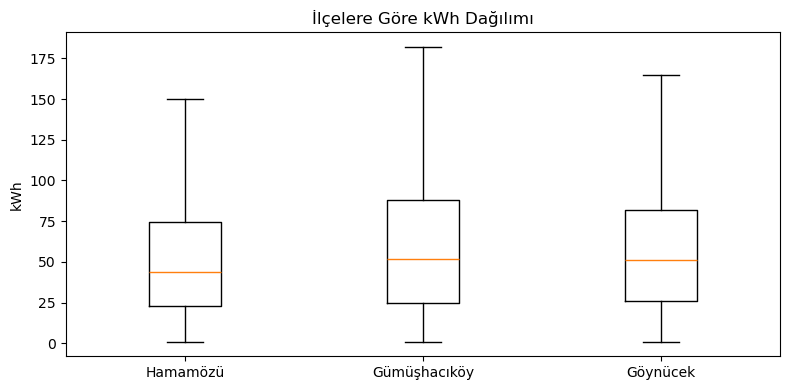

In [11]:
plt.figure(figsize=(8,4))
data = [df_kwh_positive[df_kwh_positive["ilce"]==i]["kwh"] for i in ["Hamamözü","Gümüşhacıköy","Göynücek"]]
plt.boxplot(data, tick_labels=["Hamamözü","Gümüşhacıköy","Göynücek"], showfliers=False)
plt.title("İlçelere Göre kWh Dağılımı")
plt.ylabel("kWh"); plt.tight_layout(); plt.show()

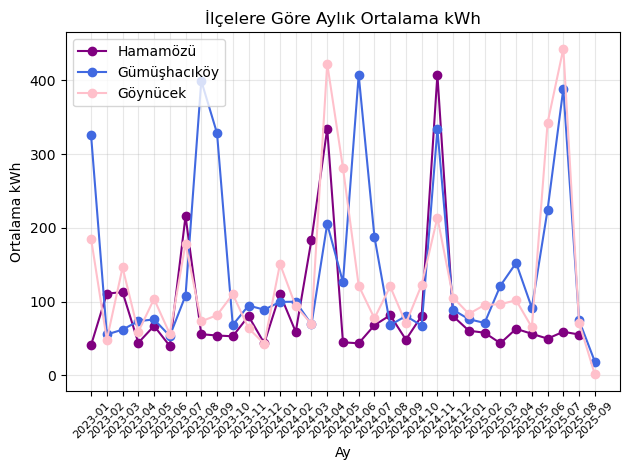

In [12]:
aylik = df_kwh_positive.groupby(["ilce","ay"])["kwh"].mean().reset_index()

for ilce, renk in zip(["Hamamözü","Gümüşhacıköy","Göynücek"], ["purple","royalblue","pink"]):
    tmp = aylik[aylik["ilce"]==ilce]
    plt.plot(tmp["ay"].astype(str), tmp["kwh"], label=ilce, color=renk, marker="o")

plt.xticks(rotation=45, fontsize=8)
plt.title("İlçelere Göre Aylık Ortalama kWh")
plt.xlabel("Ay"); plt.ylabel("Ortalama kWh")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

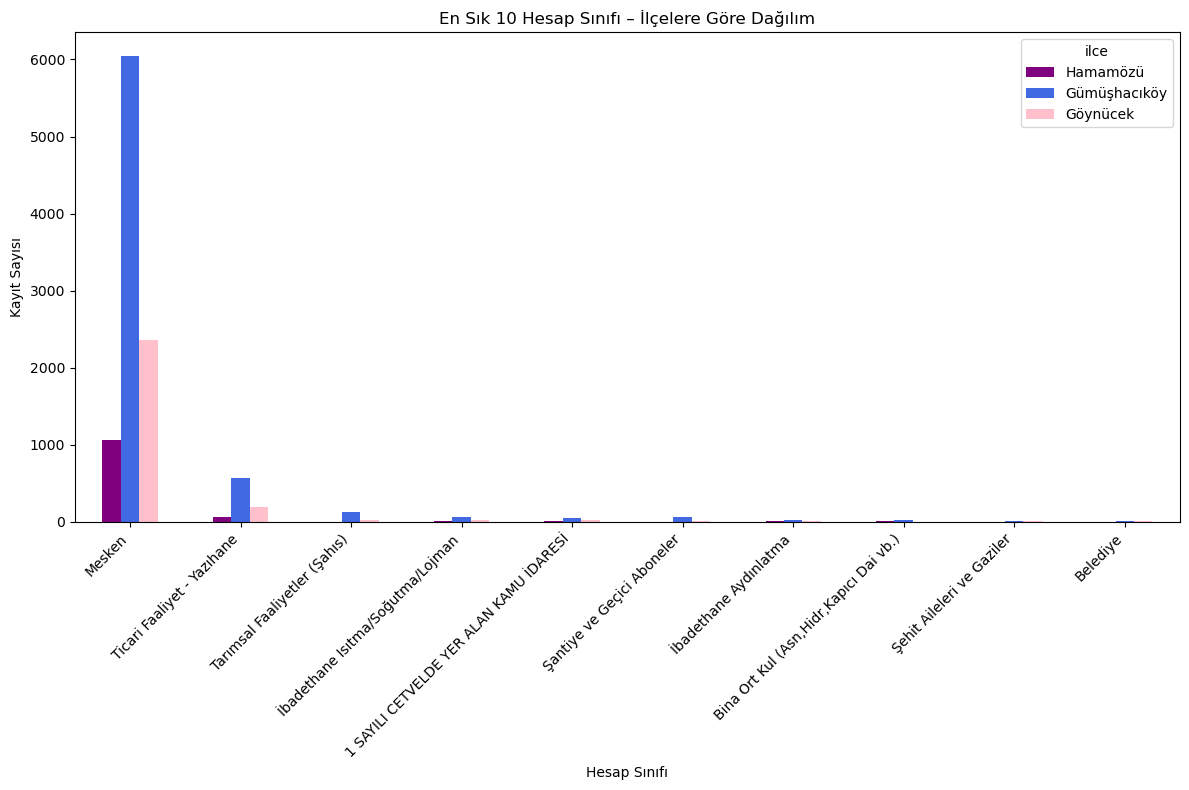

In [21]:
pivot_hs = df_kwh_positive.pivot_table(index="Hesap Sınıfı",columns="ilce",values="kwh",aggfunc="count",fill_value=0)

pivot_hs["toplam"] = pivot_hs.sum(axis=1)
pivot_hs = pivot_hs.sort_values("toplam", ascending=False).head(10).drop(columns=["toplam"])

pivot_hs = pivot_hs[["Hamamözü", "Gümüşhacıköy", "Göynücek"]]

pivot_hs.plot(kind="bar",figsize=(12,8),color=["purple","royalblue","pink"])
plt.title("En Sık 10 Hesap Sınıfı – İlçelere Göre Dağılım")
plt.ylabel("Kayıt Sayısı")
plt.xlabel("Hesap Sınıfı")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



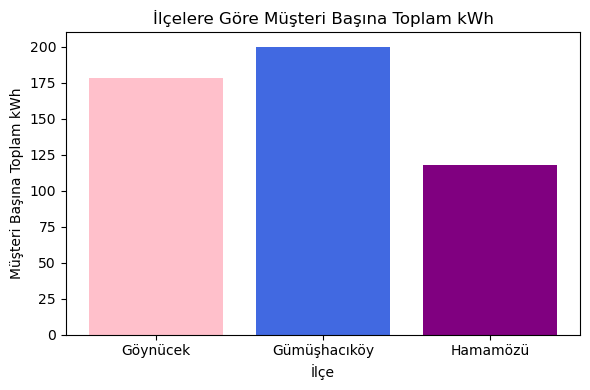

In [22]:
plt.figure(figsize=(6,4))
plt.bar(ilce_ozet["ilce"],ilce_ozet["musteri_basina_toplam_kwh"],color=["pink","royalblue","purple"])
plt.title("İlçelere Göre Müşteri Başına Toplam kWh")
plt.ylabel("Müşteri Başına Toplam kWh")
plt.xlabel("İlçe")
plt.tight_layout()
plt.show()


Bulgular: 
 Aylık ortalama tüketim analizi, tüketimde genel olarak mevsimsel etkilerin bulunduğunu göstermektedir. Ancak bu mevsimsel etkilerin ilçelere göre farklılaştığı gözlemlenmiştir. Özellikle Hamamözü ilçesinde yaz aylarında diğer ilçelere kıyasla belirgin bir tüketim artışı görülmemiştir. Bu durum, Hamamözü’nün müşteri profili ve hesap sınıfı yapısının yaz aylarında artan tüketimi tetikleyecek özellikler taşımadığından kaynaklanabilir.(Klima kullanım oranı düşük ve nüfus yazın artmıyor olabilir. Ayrıca ticari/yüksek tüketimli hesap sınıflarının diğer ilçelere kıyasla çok daha düşük olduğu görülmektedir.)
Gümüşhacıköy ve Göynücek ilçelerinde ise yaz aylarında tüketimde artış gözlemlenmiştir. Bu artış, ticari faaliyetlerin ve yaz dönemine özgü kullanım alışkanlıklarının etkisiyle ortaya çıkıyor olabilir.

İş Önerileri:
 İlçe bazında tüketim dinamiklerinin farklılık göstermesi nedeniyle, tek tip politika yerine ilçe bazlı planlama yaklaşımı benimsenebilir.
 Ticari ve yüksek tüketimli hesap sınıflarının fazla olduğu ilçelerde, enerji verimliliği bilgilendirme çalışmaları ve hedefli müşteri iletişimi ile hem tüketim kontrolü hem de tahsilat süreçlerinin iyileştirilmesi sağlanabilir.

2)
Problem: Tüm müşterileri tek bir grup olarak değerlendirmek, tahsilat risklerinin ve yüksek değerli müşteri gruplarının doğru şekilde tespit edilmesini zorlaştırır. Bu nedenle müşterilerin tüketim seviyeleri ve ödeme davranışları birlikte ele alınarak anlamlı müşteri segmentlerinin oluşturulması gerekmektedir.

H1: Ödeme davranışı düzenli olan müşteriler, şirket açısından daha yüksek değerli ve sürdürülebilir bir müşteri grubunu temsil etmektedir.
H2: Tüketim miktarı ve ödeme davranışının birlikte değerlendirilmesi, tahsilat açısından riskli müşteri gruplarının daha net şekilde belirlenmesini sağlamaktadır.

In [23]:
musteri_tuketim = (df_kwh_positive.groupby(["ilce", "sozlesme_hesap_no"]).agg(toplam_kwh=("kwh", "sum"),ortalama_kwh=("kwh", "mean"),fatura_sayisi=("kwh", "count")).reset_index())
musteri_tuketim.head()

,ilce,sozlesme_hesap_no,toplam_kwh,ortalama_kwh,fatura_sayisi
0,Göynücek,2986373,22.0,22.0,1
1,Göynücek,5667780,206.0,206.0,1
2,Göynücek,6098017,139.0,139.0,1
3,Göynücek,13017663,161.0,161.0,1
4,Göynücek,19520505,28.0,28.0,1


In [24]:
musteri_tuketim["tuketim_seviyesi"] = pd.qcut(musteri_tuketim["toplam_kwh"],q=3,labels=["Düşük Tüketim", "Orta Tüketim", "Yüksek Tüketim"])
musteri_tuketim["tuketim_seviyesi"].value_counts()


tuketim_seviyesi
Düşük Tüketim     2853
Yüksek Tüketim    2817
Orta Tüketim      2813
Name: count, dtype: int64

In [25]:
zamaninda = [
    "Son Ödeme Tarihinden Önceki Tahsilat",
    "Son Ödeme Tarihindeki Tahsilat"
]

gec = [
    "Son Ödeme (1)", "Son Ödeme (2)", "Son Ödeme (3)", "Son Ödeme (4)",
    "Son Ödeme (5)", "Son Ödeme (6-10)", "Son Ödeme (10-20)",
    "Son Ödeme (20-30)", "Son Ödeme (30-60)", "Son Ödeme (60-90)",
    "Son Ödeme (90-120)", "Son Ödeme (120-150)",
    "Son Ödeme (150-180)", "Son Ödeme (180+)"
]

df_tahsilat_1[zamaninda + gec] = df_tahsilat_1[zamaninda + gec].apply(
    lambda s: pd.to_numeric(s, errors="coerce")
)

odeme = df_tahsilat_1.copy()
odeme["zamaninda_tutar"] = odeme[zamaninda].sum(axis=1)
odeme["gec_tutar"] = odeme[gec].sum(axis=1)
odeme["toplam_tutar"] = odeme["zamaninda_tutar"] + odeme["gec_tutar"]

odeme["zamaninda_oran"] = np.where(
    odeme["toplam_tutar"] > 0,
    odeme["zamaninda_tutar"] / odeme["toplam_tutar"],
    np.nan
)
odeme = odeme.rename(columns={"Söz.hsp.(bağımsız)": "sozlesme_hesap_no"})
odeme = odeme[["sozlesme_hesap_no", "zamaninda_oran", "gec_tutar"]]
odeme.head()

,sozlesme_hesap_no,zamaninda_oran,gec_tutar
0,9374624783,0.0,5.0
1,236184905,NaN,0.0
2,9657731015,NaN,0.0
3,9554442880,NaN,0.0
4,6031642522,NaN,0.0


In [27]:
df_sgm = musteri_tuketim.merge(odeme,on="sozlesme_hesap_no",how="left")
df_sgm.head()


,ilce,sozlesme_hesap_no,toplam_kwh,ortalama_kwh,fatura_sayisi,tuketim_seviyesi,zamaninda_oran,gec_tutar
0,Göynücek,2986373,22.0,22.0,1,Düşük Tüketim,NaN,0.0
1,Göynücek,2986373,22.0,22.0,1,Düşük Tüketim,NaN,0.0
2,Göynücek,2986373,22.0,22.0,1,Düşük Tüketim,NaN,0.0
3,Göynücek,2986373,22.0,22.0,1,Düşük Tüketim,NaN,0.0
4,Göynücek,2986373,22.0,22.0,1,Düşük Tüketim,NaN,0.0


In [29]:
df_sgm["odeme_davranisi"] = np.where(df_sgm["zamaninda_oran"].isna(),"Ödeme Yok",np.where(df_sgm["zamaninda_oran"] >= 0.8, "İyi Ödeme", "Riskli Ödeme"))
df_sgm["odeme_davranisi"].value_counts()


odeme_davranisi
Ödeme Yok       131097
İyi Ödeme        35661
Riskli Ödeme     23056
Name: count, dtype: int64

In [31]:
df_sgm["segment"] = (df_sgm["tuketim_seviyesi"].astype(str)+ " / " + df_sgm["odeme_davranisi"])
df_sgm["segment"].value_counts()

segment
Yüksek Tüketim / Ödeme Yok       48886
Orta Tüketim / Ödeme Yok         46297
Düşük Tüketim / Ödeme Yok        35914
Yüksek Tüketim / İyi Ödeme       13871
Orta Tüketim / İyi Ödeme         12541
Düşük Tüketim / İyi Ödeme         9249
Yüksek Tüketim / Riskli Ödeme     8794
Orta Tüketim / Riskli Ödeme       7904
Düşük Tüketim / Riskli Ödeme      6358
Name: count, dtype: int64

In [32]:
segment_ozet = df_sgm.groupby("segment").agg(
    musteri_sayisi=("sozlesme_hesap_no", "nunique"),
    ort_toplam_kwh=("toplam_kwh", "mean"),
    ort_zamaninda_oran=("zamaninda_oran", "mean"),
    toplam_gec_tutar=("gec_tutar", "sum")
).reset_index()

segment_ozet.sort_values("musteri_sayisi", ascending=False)

,segment,musteri_sayisi,ort_toplam_kwh,ort_zamaninda_oran,toplam_gec_tutar
1,Düşük Tüketim / Ödeme Yok,2841,20.699839,NaN,0.0
7,Yüksek Tüketim / Ödeme Yok,2817,504.881459,NaN,0.0
4,Orta Tüketim / Ödeme Yok,2810,60.602372,NaN,0.0
8,Yüksek Tüketim / İyi Ödeme,1999,465.219306,1.000000,0.0
5,Orta Tüketim / İyi Ödeme,1960,60.966271,1.000007,35.0
6,Yüksek Tüketim / Riskli Ödeme,1781,380.957130,0.000359,9180728.0
3,Orta Tüketim / Riskli Ödeme,1757,60.513031,0.000000,1988643.0
0,Düşük Tüketim / Riskli Ödeme,1705,20.271941,0.000156,880669.0
2,Düşük Tüketim / İyi Ödeme,1668,21.004433,1.000000,0.0


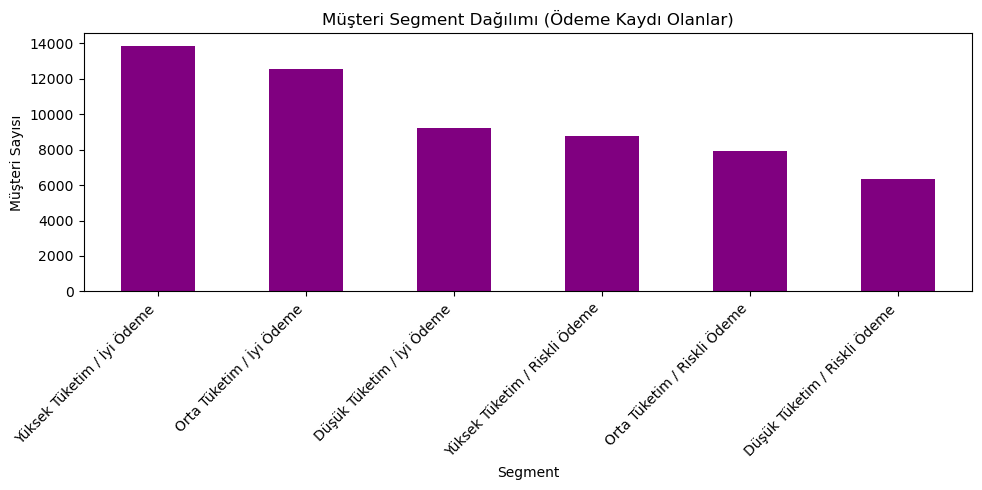

In [36]:
df_sgm[df_sgm["odeme_davranisi"] != "Ödeme Yok"]["segment"].value_counts().plot(kind="bar",figsize=(10,5),color="purple")

plt.title("Müşteri Segment Dağılımı (Ödeme Kaydı Olanlar)")
plt.ylabel("Müşteri Sayısı")
plt.xlabel("Segment")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Bulgular: 
 Ödeme kaydı bulunan müşteriler incelendiğinde, yüksek tüketimli müşteriler arasında iyi ödeme davranışı sergileyen müşteri grubunun ilk sırada olduğu görülmektedir.
 Yüksek tüketim yaoan ancak riskli ödeme davranışı gösteren müşteriler, müşteri sayısı açısından daha az olsa da yüksek tüketim seviyeleri nedeniyle tahsilat açısından kritik bir risk grubu oluşturmaktadır.
 Orta ve düşük tüketimli segmentlerde ödeme davranışlarının daha dengeli olduğu, riskin biraz daha düşük kaldığı söylenebilir. Bu durum, tahsilat riskinin özellikle yüksek tüketimli müşteri segmentlerinde yoğunlaştığını göstermektedir.
 

İş Önerileri:
 Yüksek Tüketim / Riskli Ödeme segmenti, tahsilat süreçlerinde öncelikli olarak izlenmelidir. Bu müşteri grubuna yönelik otomatik hatırlatmalar ve yapılandırılmış ödeme planları uygulanabilir.
 Ödeme kaydı bulunmayan müşteriler düzenli olarak izlenerek zaman içerisinde bu müşterilerin ödeme davranışlarının riskli segmentlere kayıp kaymadığı kontrol edilmelidir.